In [1]:
import pandas as pd
import numpy as np

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from wordcloud import WordCloud

SELECT_YEAR = 2017

DATA_PATH = '../data'
PLOT_PATH = '../docs/plots/{}'.format(SELECT_YEAR)

In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(5)

CPU times: user 85.9 ms, sys: 3.96 ms, total: 89.9 ms
Wall time: 92.2 ms
(8652, 5) docs shape


,id,titulo,clean,wct,wcc
79,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",9,9
80,104124422364023,A gold-standard social media corpus for urban ...,"[gold, standard, social, media, corpus, urban,...",8,7
94,104124422364023,A Framework for Spatial Analytics using Hetero...,"[framework, spatial, analyt, use, heterogen, d...",9,7
140,105670521813027,Gene expression analysis in Musa acuminata dur...,"[gene, express, analysi, musa, acuminata, comp...",12,9
141,105670521813027,Mitogenome sequence accuracy using different e...,"[mitogenom, sequenc, accuraci, use, differ, el...",7,7


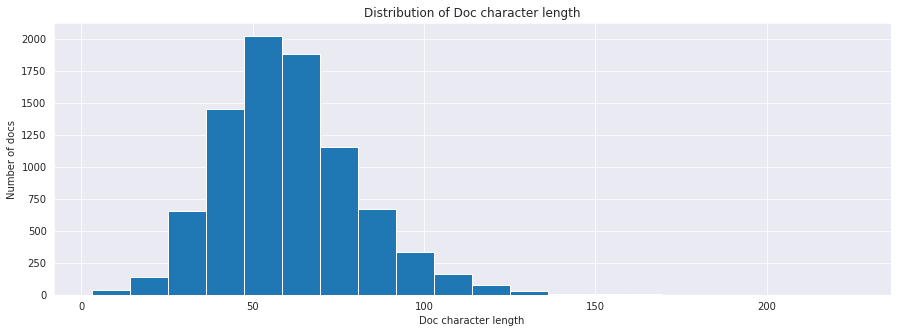

In [3]:
df['clean'] = df['clean'].apply(lambda x: ' '.join(x))

fig = plt.figure(figsize=(15, 5))

doc_lens = [len(d) for d in df.clean]

plt.hist(doc_lens, bins = 20)
plt.title('Distribution of Doc character length')
plt.ylabel('Number of docs')
plt.xlabel('Doc character length')
plt.show()

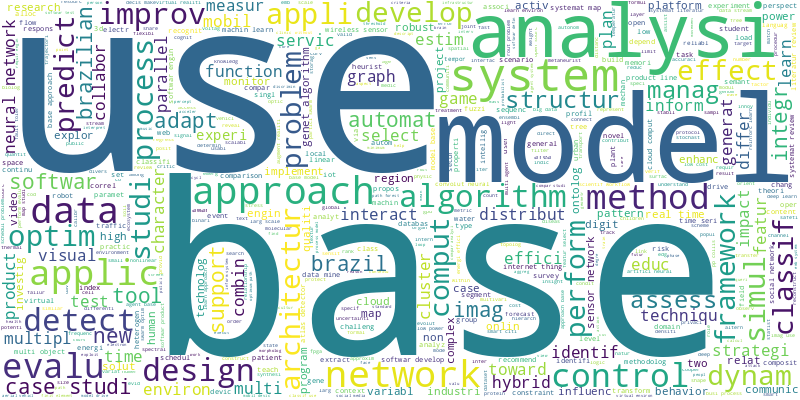

In [4]:
long_string = ' '.join(list(df.clean.values))

wordcloud = WordCloud(
                width=800, 
                height=400,
                background_color="white",
                max_words=5000,
                contour_width=3,
                contour_color='steelblue'
                ).generate(long_string)

wordcloud.to_image()

In [5]:
def get_top_ngram(corpus, gram, n=None):
    vec = CountVectorizer(ngram_range=(gram,gram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def graph_ngram(gram, n=None):
    common_words = get_top_ngram(df.clean,gram,n)
    df_ngram = pd.DataFrame(common_words, columns = ['ngram' , 'count'])
    x = df_ngram['ngram']
    y = df_ngram['count']

    fig = plt.figure(figsize=(20,7))

    g = sns.barplot(x=x, y=y, order=x, palette='Blues_d')
    g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=14)

    plt.yticks(fontsize=14)
    plt.xlabel('ngrams', fontsize=14)
    plt.ylabel('Docs', fontsize=14)
    plt.title('ngram={} - Top {} in docs'.format(gram,n), fontsize=17)
    del x, y, df_ngram

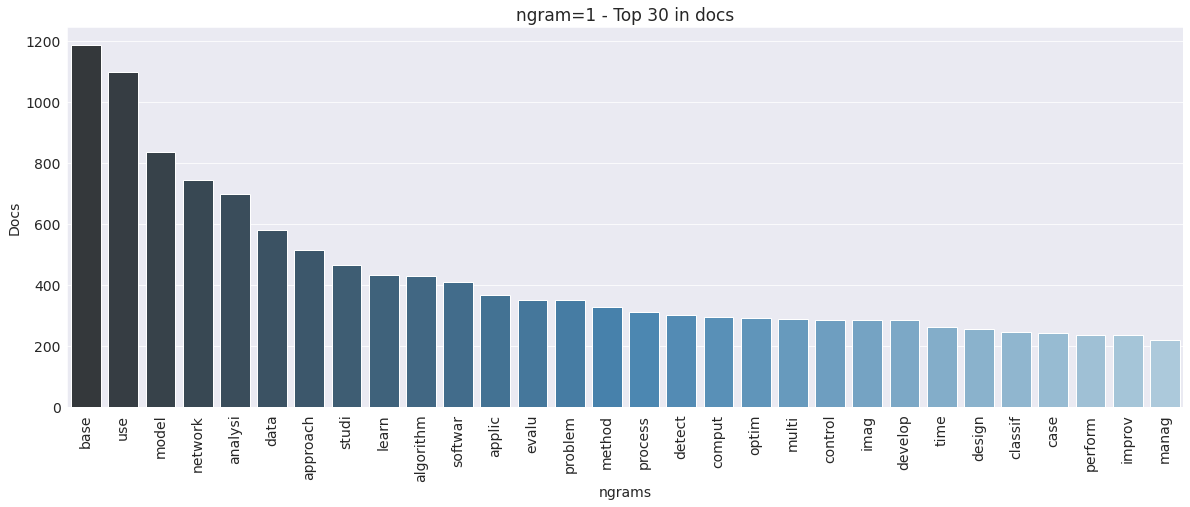

In [6]:
graph_ngram(1,30)

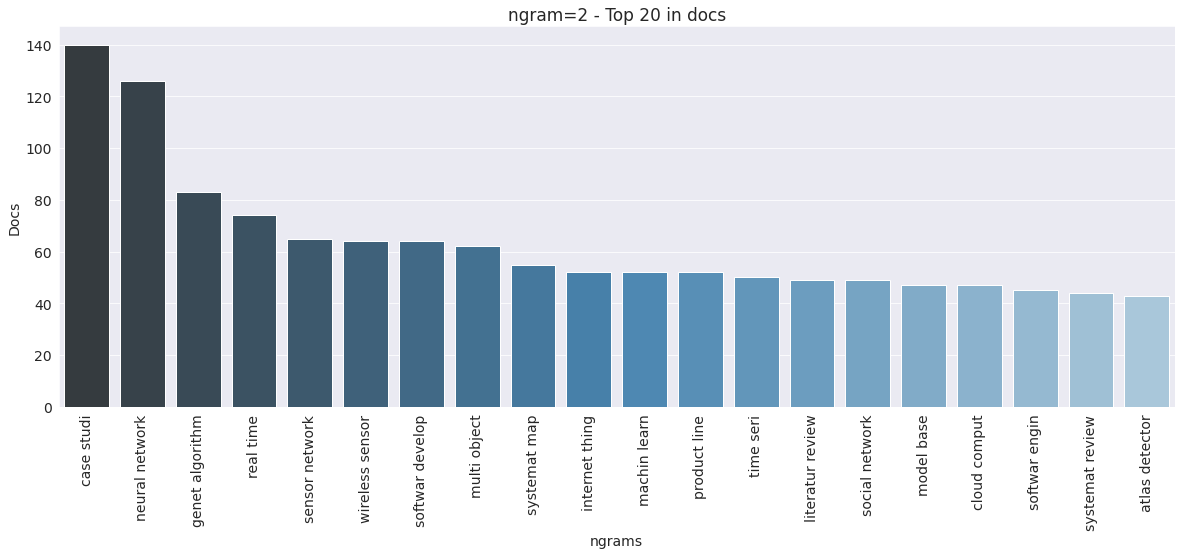

In [7]:
graph_ngram(2,20)

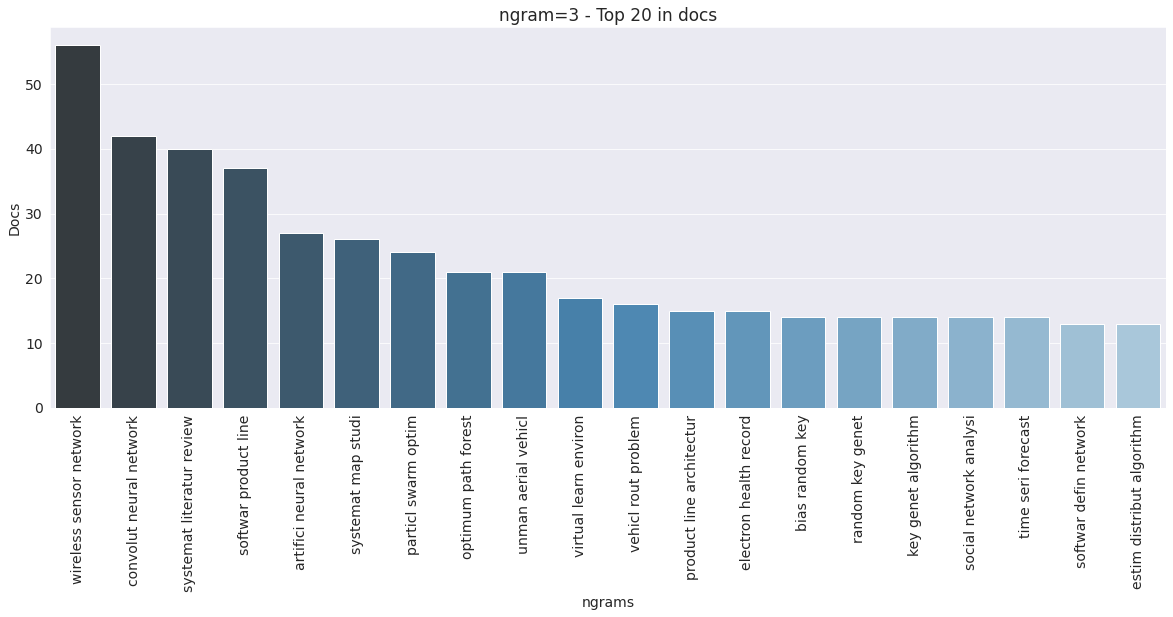

In [8]:
graph_ngram(3,20)

In [9]:
vectorizer = CountVectorizer(
    min_df=0.005,
    max_df=0.8,
    stop_words='english',
    lowercase=True,
    analyzer='word',
    token_pattern='[a-zA-Z0-9]{3,}',
    ngram_range=(1,3),
    max_features=5000)

data_vectorized = vectorizer.fit_transform(df.clean)
data_dense = data_vectorized.todense()

print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.3255350683962905 %


In [10]:
lda_model = LatentDirichletAllocation(
    n_components=20, # Number of topics
    learning_method='online',
    random_state=0,
    n_jobs = -1) # Use all available CPUs

lda_output = lda_model.fit_transform(data_vectorized)

print("Log likelihood: ", lda_model.score(data_vectorized))
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Log likelihood:  -235217.51270714577
Perplexity:  379.01928718323927


In [11]:
ldavis = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(ldavis, './docs/{}-LDA.html'.format(SELECT_YEAR))
pyLDAvis.display(ldavis)

In [12]:
# Construct the k-means clusters
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.18  0.27  0.17  0.16  0.22  0.2   0.18  0.16  0.25  0.26  0.24  0.22
   0.25  0.35  0.19  0.27  0.17  0.23  0.19  0.19]
 [-0.03 -0.51 -0.02  0.    0.03 -0.08 -0.03  0.03 -0.14 -0.19 -0.04  0.01
  -0.08  0.82 -0.02 -0.03  0.01  0.   -0.01 -0.06]]
Perc of Variance Explained: 
 [0.   0.08]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

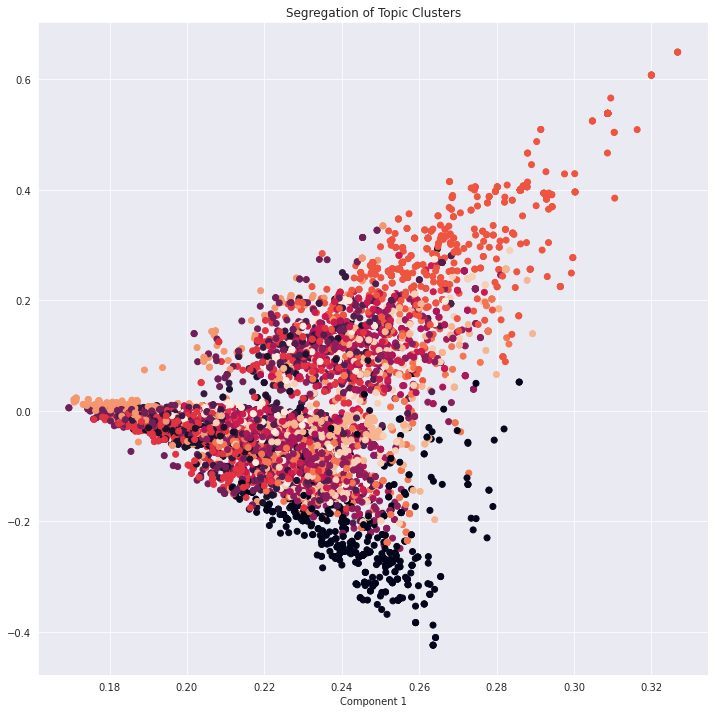

In [13]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [14]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['W'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['T'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19
T0,comput,automat,estim,search,identif,use,user,knowledg,enhanc,paramet,heterogen,intellig,relat,signal,cloud comput,public,base,model,forecast,servic
T1,network,improv,graph,neural,use,neural network,social,base,video,autonom,optic,phase,onlin,databas,alloc,singl,match,convolut,electr,content
T2,studi,case,manag,brazil,case studi,awar,region,task,busi,evolut,construct,public,communiti,explor,use,approach,softwar,novel,autonom,scientif
T3,techniqu,use,project,real,time,heurist,identifi,real time,novel,explor,extract,dimension,protocol,element,method,track,uncertainti,gpu,program,visual
T4,softwar,develop,design,environ,impact,non,collabor,linear,schedul,theori,research,comparison,softwar develop,autom,defin,virtual,teach,use,support,applic
T5,applic,sensor,network,low,virtual,wireless,smart,use,cost,survey,build,internet,communic,sensor network,wireless sensor,realiti,thing,mobil,wireless sensor network,internet thing
T6,measur,new,cluster,character,level,decis,human,semant,base,space,locat,core,ecosystem,index,determin,propos,direct,use,multi,scale
T7,map,systemat,engin,machin,review,requir,softwar,web,robot,analyt,type,challeng,systemat map,machin learn,cross,protein,softwar engin,perspect,systemat review,base
T8,data,function,inform,complex,open,base,stream,use,oper,patient,larg,sourc,composit,point,similar,electron,big,communiti,cognit,spatial
T9,analysi,imag,energi,perform,strategi,visual,activ,industri,compar,tree,experiment,use,text,analyz,hevc,effici,multi,research,fault,applic
